# IOPS Test Report

## Experiment Environment

<table>
  <tr>
    <th colspan="2"><b>Set Up Parameters</b></th>
  </tr>
  <tr>
    <td><b>Active Range</b></td>
    <td>75%<br></td>
  </tr>
  <tr>
    <td><b>Pre Condition 1</b></td>
    <td>SEQ 128KB W</td>
  </tr>
  <tr>
    <td>    TOIO - TC/QD</td>
    <td>TC 2 / QD 16</td>
  </tr>
  <tr>
    <td>    Duration</td>
    <td>2 x User Capacity</td>
  </tr>
  <tr>
    <td><b>Purge Method</b></td>
    <td>None</td>
  </tr>
  <tr>
    <td><b>Write Cache</b></td>
    <td>Enabled</td>
  </tr>
</table>


<table>
  <tr>
    <th colspan="2"><b>Test Parameters</b></th>
  </tr>
  <tr>
    <td><b>Active Range</b></td>
    <td>75%</td>
  </tr>
  <tr>
    <td><b>Test Stimulus 1</b></td>
    <td>SEQ</td>
  </tr>
  <tr>
    <td>    Block Size (Outer Loop)</td>
    <td>1024KB, 128KB, 64KB, 32KB, 16KB, 8KB, 4KB, 512B</td>
  </tr>
  <tr>
    <td>    R/W Mix (Inner Loop)</td>
    <td>100/0, 95/5, 65/35, 50/50, 35/65, 5/95, 0/100</td>
  </tr>
  <tr>
    <td>    TOIO - TC/QD</td>
    <td>TC 2 / QD 16</td>
  </tr>
</table>

---

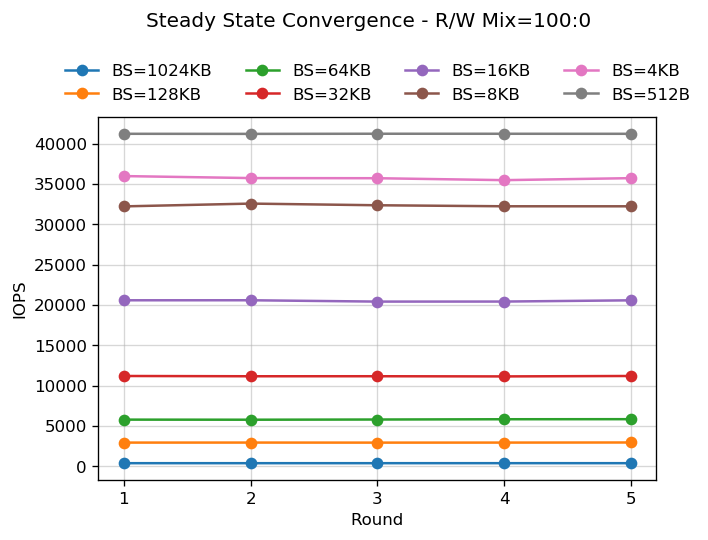

---

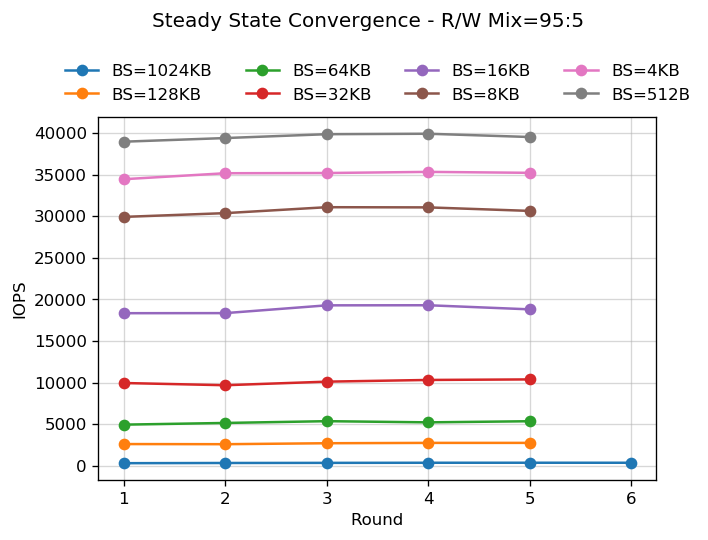

---

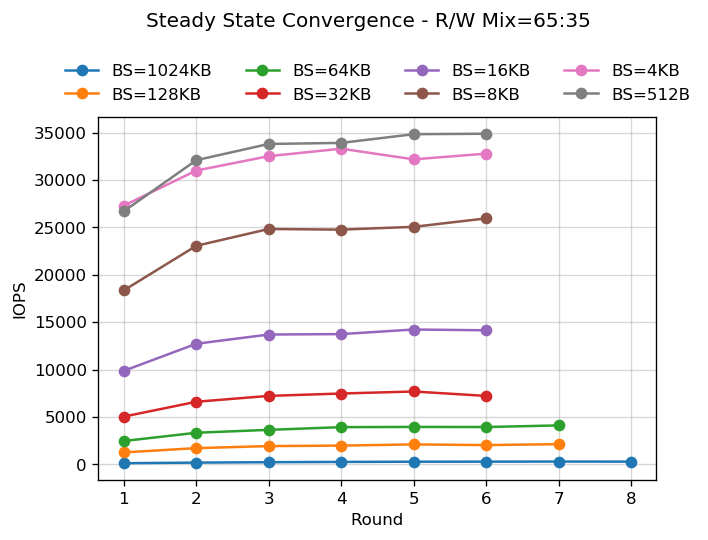

---

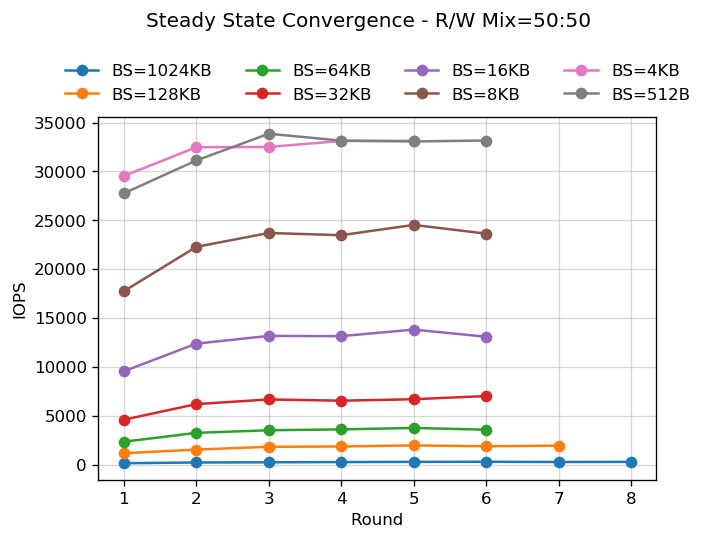

---

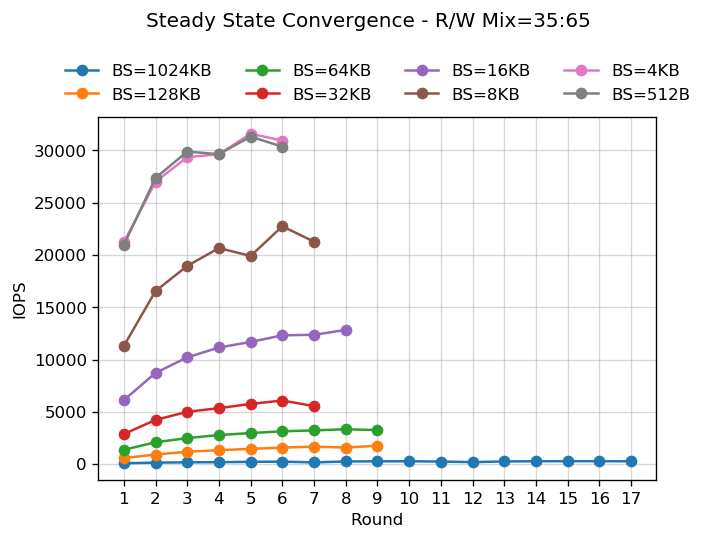

---

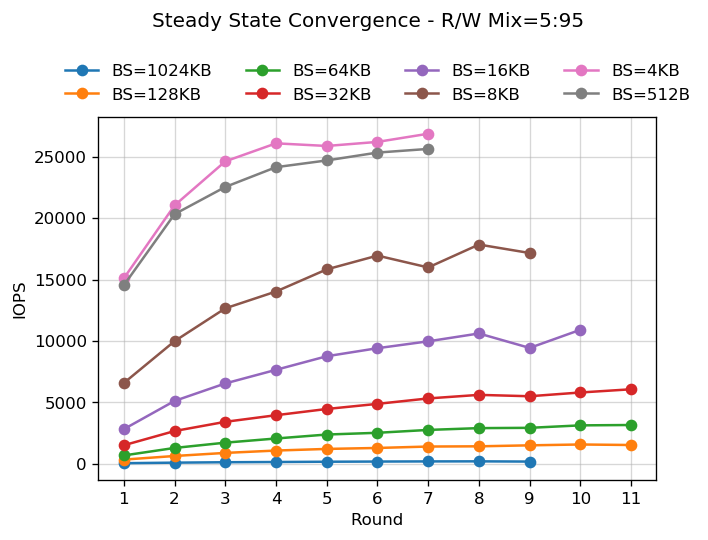

---

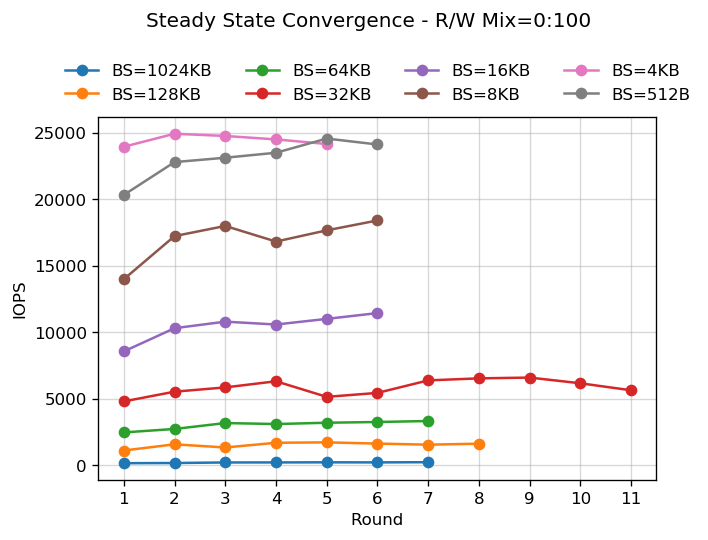

---

Measurement Window,1 - 5
Ave. value in Measurement Window,24474.606
Calculated allowed range in Measurement Window (+-10% of Ave.),26922.067 (Max) / 22027.146 (Min)
Measured range in Measurement Window,24943.302 (Max) / 23965.567 (Min) (pass)
Slope of best linear fit in Measurement Window (must be <= 10%),0.011% (pass)
Least Squares Linear Fit Formula,-1.374 x + 2.448e+04


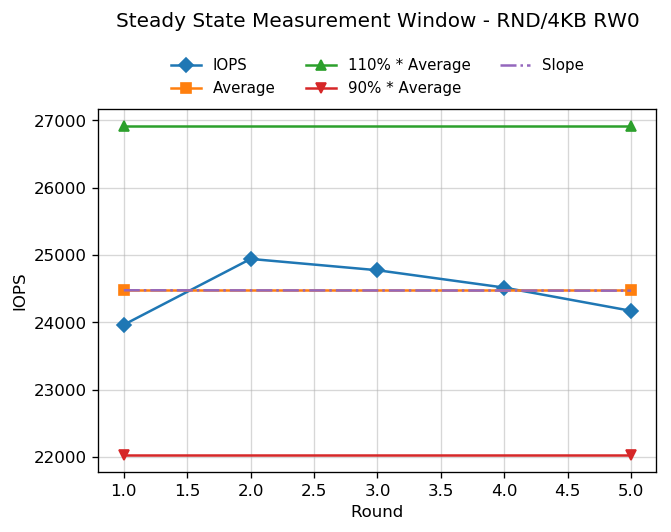

---

Measurement Window,3 - 7
Ave. value in Measurement Window,3898.331
Calculated allowed range in Measurement Window (+-10% of Ave.),4288.165 (Max) / 3508.498 (Min)
Measured range in Measurement Window,4095.466 (Max) / 3626.193 (Min) (pass)
Slope of best linear fit in Measurement Window (must be <= 10%),4.879% (pass)
Least Squares Linear Fit Formula,95.11 x + 3423


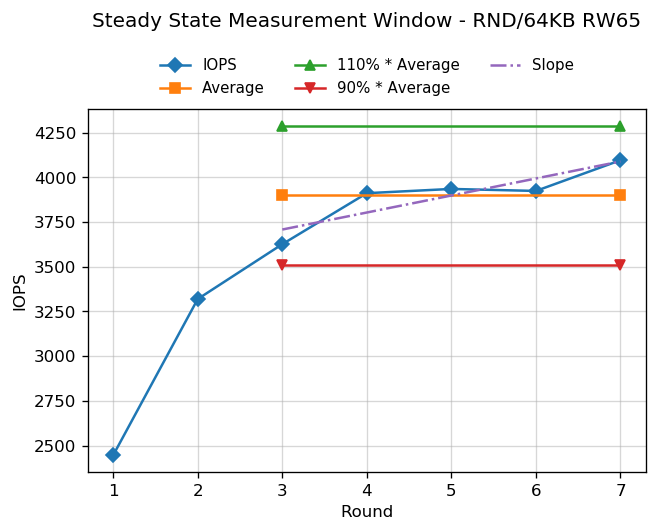

---

Measurement Window,1 - 5
Ave. value in Measurement Window,372.347
Calculated allowed range in Measurement Window (+-10% of Ave.),409.581 (Max) / 335.112 (Min)
Measured range in Measurement Window,373.660 (Max) / 371.686 (Min) (pass)
Slope of best linear fit in Measurement Window (must be <= 10%),0.191% (pass)
Least Squares Linear Fit Formula,0.3547 x + 371.3


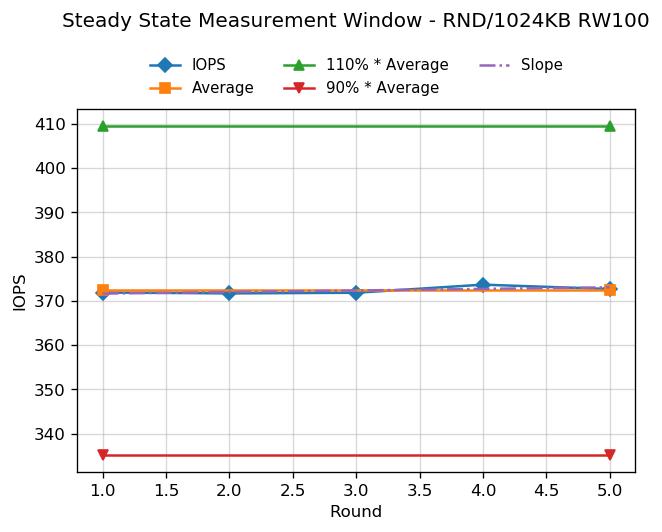

---

In [2]:
from common import util
from IPython.display import display, Markdown, HTML

import matplotlib.pyplot as plt
import numpy as np


BLOCK_SIZES = ['1024KB', '128KB', '64KB', '32KB', '16KB', '8KB', '4KB', '512B']
RWMIXREADS = [100, 95, 65, 50, 35, 5, 0]

# I/O patterns for ploting IOPS SS measurement window:
#   - Ave RND 4KiB Write
#   - Ave RND 64K R/W% 65:35
#   - Ave RND 1024K Read
MEASUREMENT_WINDOW_VARS_INXES = [(6, 6), (2, 2), (0, 0)]


def __get_avg_iops(profiles_dirname, bs, rwmixread):
    """Get all average IOPS in profiles matching the block size and rwmixread.

    Args:
        profiles_dirname (str): The name of the profile folder.
        bs (str): The block size.
        rwmixread (int): The percentage of read in read/write mix I/O.

    """
    rounds = []
    values = []

    round_profile_pairs = util.get_profiles(profiles_dirname, bs, rwmixread)
    for rp in round_profile_pairs:
        rounds.append(rp[0])
        profile = rp[1]

        runtime = util.get_num_in(profile, ['read', 'runtime'])
        if runtime == 0:
            runtime = util.get_num_in(profile, ['write', 'runtime'])
        runtime_in_seconds = runtime / 1000
        
        total_iops = util.get_num_in(profile, ['read', 'total_ios']) + \
                        util.get_num_in(profile, ['write', 'total_ios'])

        values.append(total_iops / runtime_in_seconds)

    return rounds, values


def __create_subplots():
    fig, ax = plt.subplots()

    # Change the size of figure
    # See https://stackoverflow.com/a/4306340
    fig.set_dpi(util.FIG_DPI)

    return fig, ax


def plot_ss_convergence(profiles_dirname):
    for rwmixread in RWMIXREADS:
        display(Markdown('---'))
        fig, ax = __create_subplots()

        max_round = 1
        bars = []
        for bs in BLOCK_SIZES:
            rounds, values = __get_avg_iops(profiles_dirname, bs, rwmixread)
            bars.append(ax.errorbar(rounds, values, fmt='-o'))

            max_round = max(rounds[-1], max_round)

        ax.set_xticks(range(1, max_round + 1))
        ax.grid(which='major', alpha=0.5)
        ax.set_ylabel('IOPS')
        ax.set_xlabel('Round')

        plt.legend(
                bars,
                ['BS=' + bs for bs in BLOCK_SIZES],
                loc=8,
                bbox_to_anchor=(0.5, 1),
                frameon=False,
                ncol=4)
        plt.suptitle(
            'Steady State Convergence - R/W Mix=' + \
            str(rwmixread) + ':' + str(100 - rwmixread),
            y=1.1)
        plt.show()


def plot_ss_measurement_window(profiles_dirname):
    for vars_idxes in MEASUREMENT_WINDOW_VARS_INXES:
        display(Markdown('---'))
        fig, ax = __create_subplots()

        bs = BLOCK_SIZES[vars_idxes[0]]
        rwmixread = RWMIXREADS[vars_idxes[1]]

        rounds, values = __get_avg_iops(
            profiles_dirname, bs, rwmixread)

        bars, rounds_in_window, values_in_window, avg_value, poly = \
            util.plot_measurement_window(ax, rounds, values)

        ax.set_ylabel('IOPS')
        ax.set_xlabel('Round')

        verification_report = '''\
        <table>
          <caption><b>Block Size = {bs}, R/W Mix % = {rwmixread}:{rwmixwrite}</b></caption>
          <tr>
            <td><b>Measurement Window</b></td>
            <td>{start} - {end}</td>
          </tr>
          <tr>
            <td><b>Ave. value in Measurement Window</b></td>
            <td>{avg:.3f}</td>
          </tr>
          <tr>
            <td><b>Calculated allowed range in Measurement Window (+-10% of Ave.)</b></td>
            <td>{excursion_up_val:.3f} (Max) / {excursion_down_val:.3f} (Min)</td>
          </tr>
          <tr>
            <td><b>Measured range in Measurement Window</b></td>
            <td>{max_val:.3f} (Max) / {min_val:.3f} (Min)  (<b>pass</b>)</td>
          </tr>
          <tr>
            <td><b>Slope of best linear fit in Measurement Window (must be &lt;= 10%)</b></td>
            <td>{max_excursion_percentage:.3f}% (<b>pass</b>)</td>
          </tr>
          <tr>
            <td><b>Least Squares Linear Fit Formula</b></td>
            <td>{formula}</td>
          </tr>
        </table><br/>\
        '''.format(
            bs=bs,
            rwmixread=rwmixread,
            rwmixwrite=100 - rwmixread,
            start=rounds_in_window[0],
            end=rounds_in_window[-1],
            avg=avg_value,
            excursion_up_val=avg_value * util.EXCURSION_UP,
            excursion_down_val = avg_value * util.EXCURSION_DOWN,
            max_val=max(values_in_window),
            min_val=min(values_in_window),
            max_excursion_percentage=100 * max(abs(1 - poly(rounds_in_window[0]) / avg_value),
                                               abs(1 - poly(rounds_in_window[-1]) / avg_value)),
            formula=poly)
        display(HTML(verification_report))

        plt.legend(
                bars,
                ['IOPS', 'Average', '110% * Average', '90% * Average', 'Slope'],
                loc=8,
                bbox_to_anchor=(0.5, 1),
                frameon=False,
                ncol=3,
                prop={'size': 9})
        plt.title('Steady State Measurement Window - RND/' + bs + ' RW' + str(rwmixread),
                  y=1.2)
        plt.show()


def plot_measurement_window_tabular(profiles_dirname):
    rwmixread_tds = ''
    for rwmixread in RWMIXREADS:
        rwmixread_tds += '<td>{rwmixread}/{rwmixwrite}</td>'.format(
            rwmixread=rwmixread,
            rwmixwrite=(100 - rwmixread))

    avg_iops_trs = ''
    for bs in BLOCK_SIZES:
        avg_iops_tds = '<td>{bs}</td>'.format(bs=bs)
        for rwmixread in RWMIXREADS:
            rounds, values = __get_avg_iops(profiles_dirname, bs, rwmixread)
            avg_value = np.mean(util.get_values_in_window(values))
            avg_iops_tds += '<td>{avg_value:.3f}</td>'.format(avg_value=avg_value)
            
        avg_iops_trs += '<tr>' + avg_iops_tds + '</tr>'

    tabular_data = '''\
    <table>
      <caption><b>IOPS - ALL RW Mix & BS - Tabular Data</b></caption>
      <tr>
        <td rowspan="2"><b>Block Size</b></td>
        <td colspan="{num_rwmixreads}"><b>Read / Write Mix %</b></td>
      </tr>
      <tr>
        {rwmixread_tds}
      </tr>
      {avg_iops_trs}
    </table>\
    '''.format(
        num_rwmixreads=len(RWMIXREADS),
        rwmixread_tds=rwmixread_tds,
        avg_iops_trs=avg_iops_trs)
    
    display(Markdown('---'))
    display(HTML(tabular_data))


profiles_dirname = 'usb3_iops'

plot_ss_convergence(profiles_dirname)
plot_ss_measurement_window(profiles_dirname)
plot_measurement_window_tabular(profiles_dirname)

## Notes

### Definition of ***Steady State***

```
A device is said to be in Steady State when, for the dependent variable (y)
being tracked:
    a) Range(y) is less than 10% of Ave(y): Max(y)-Min(y) within the
       Measurement Window is no more than 10% of the Ave(y) within the
       Measurement Window; and
    b) Slope(y) is less than 10%: Max(y)-Min(y), where Max(y) and Min(y) are
       the maximum and minimum values on the best linear curve fit of the
       y-values within the Measurement Window, is within 10% of Ave(y) value
       within the Measurement Window.
```

## References

- [Solid State Storage (SSS) Performance Test Specification (PTS) v2.0.1](https://www.snia.org/sites/default/files/technical_work/PTS/SSS_PTS_2.0.1.pdf)